## Import Modules

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import matplotlib
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40) 

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)


import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

## Create DataFrame

In [2]:
data = pd.read_csv("historic_sales.csv", names=['Store','Dept','Date','Weekly_Sales','isHoliday'],sep='|', header=0)
features = pd.read_csv("features.csv",sep='|', header=0, names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("store_info.csv", names=['Store','Type','Size'],sep=';', header=0)

C:\Users\Abhishek\Anaconda2\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,Store,Dept,Date,Weekly_Sales,isHoliday
0,1,1,2010-02-05,"24924,5",False
1,1,1,2010-02-12,"46039,49",True
2,1,1,2010-02-19,"41595,55",False
3,1,1,2010-02-26,"19403,54",False
4,1,1,2010-03-05,"21827,9",False


__Note:__ The describe() function creates a 7 number summary of the loaded time series including mean, standard deviation, median, minimum, and maximum of the observations.

In [4]:
#Replace ',' with ''
data['Weekly_Sales'] = data['Weekly_Sales'].replace(np.nan, '', regex=True).str.replace(',','')

In [5]:
# Fill the nan values and convert the datatype from str to int.
data['Weekly_Sales'] = pd.to_numeric(data['Weekly_Sales'], errors='coerce').fillna(0).astype(int)

In [6]:
#total = data.isnull().sum(axis=0).sort_values(ascending=False)
#percent = ((data.isnull().sum(axis=0)/data.isnull().count(axis=0))*100).sort_values(ascending=False)

# count the number of null values in the column and their perecentage of the total data
#missing_data_columns = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#missing_data_columns

## Convert data['date'] from string to datetime

In [7]:
# Convert object to datetime
data['Date'] = pd.to_datetime(data['Date'], errors = 'coerce')

In [8]:
df = data.groupby('Date')['Weekly_Sales'].sum().reset_index()

In [9]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq=None)

In [10]:
df.head()

,Weekly_Sales
Date,
2010-02-05,4.342546e+09
2010-02-12,4.315691e+09
2010-02-19,4.303063e+09
2010-02-26,3.959016e+09
2010-03-05,4.142275e+09


In [11]:
#copy_data=df.copy()

In [12]:
#opy_data.head()

In [13]:
import calendar
data['Day_Of_Week'] = data['Date'].dt.dayofweek.fillna(0).astype(int)
data['Month'] = data['Date'].dt.month.fillna(0).astype(int)
data['Year'] = data['Date'].dt.year.fillna(0).astype(int)
data['Day'] = data['Date'].dt.day.fillna(0).astype(int)

In [14]:
data.head()

,Store,Dept,Date,Weekly_Sales,isHoliday,Day_Of_Week,Month,Year,Day
0,1,1,2010-02-05,249245,False,4,2,2010,5
1,1,1,2010-02-12,4603949,True,4,2,2010,12
2,1,1,2010-02-19,4159555,False,4,2,2010,19
3,1,1,2010-02-26,1940354,False,4,2,2010,26
4,1,1,2010-03-05,218279,False,4,3,2010,5


In [15]:
# For simplicity for now I am only considering Store 1.
dataset=data[data.Store==1]

## Set Date as the index

In [16]:
dataset = dataset.set_index(dataset['Date'])

In [17]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,isHoliday,Day_Of_Week,Month,Year,Day
Date,,,,,,,,,
2010-02-05,1,1,2010-02-05,249245,False,4,2,2010,5
2010-02-12,1,1,2010-02-12,4603949,True,4,2,2010,12
2010-02-19,1,1,2010-02-19,4159555,False,4,2,2010,19
2010-02-26,1,1,2010-02-26,1940354,False,4,2,2010,26
2010-03-05,1,1,2010-03-05,218279,False,4,3,2010,5


## Outlier Removal 

In [18]:
dataset_copy = dataset.copy()
dataset_copy = dataset_copy.drop(['Date', 'isHoliday'], axis = 1)
dataset_copy.head()

,Store,Dept,Weekly_Sales,Day_Of_Week,Month,Year,Day
Date,,,,,,,
2010-02-05,1,1,249245,4,2,2010,5
2010-02-12,1,1,4603949,4,2,2010,12
2010-02-19,1,1,4159555,4,2,2010,19
2010-02-26,1,1,1940354,4,2,2010,26
2010-03-05,1,1,218279,4,3,2010,5


In [19]:
#Q1 = dataset_copy['Weekly_Sales'].quantile(0.25)
#Q3 = dataset_copy['Weekly_Sales'].quantile(0.75)
#IQR = Q3 - Q1
#print(IQR)

In [20]:
#outlier_copy = ((dataset_copy['Weekly_Sales'] < (Q1 - 1.5 * IQR)) |(dataset_copy['Weekly_Sales'] > (Q3 + 1.5 * IQR)))

In [21]:
#dataset_weekly_out = dataset_copy['Weekly_Sales'][~outlier_copy]

In [22]:
#dataset_weekly_out.isnull().shape

## ...........................................................................

In [23]:
#import seaborn as sns
#sns.boxplot(x=dataset['Weekly_Sales'])

In [24]:
# Without Outlier
#import seaborn as sns
#sns.boxplot(x=dataset_weekly_out)
#plt.savefig("Outlier Removal")

In [25]:
def fig(data,name, x, y):
    plt.figure(figsize=(10,6))
    data.plot()
    plt.savefig(name)
    plt.xlabel(x)
    plt.ylabel(y)

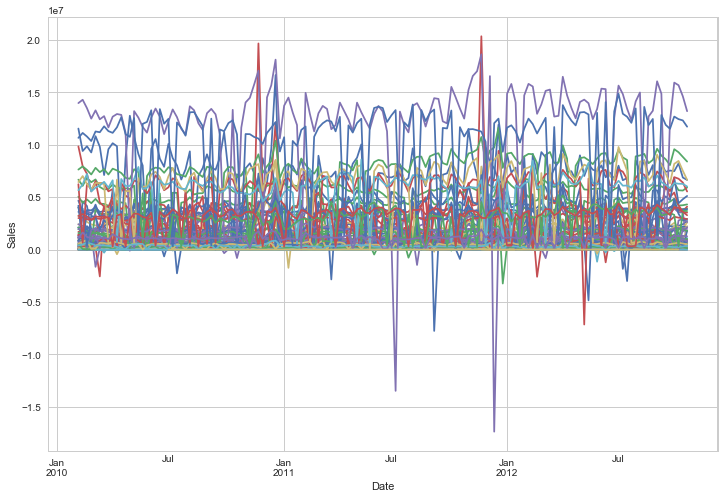

In [26]:
plt.figure(figsize=(12,8))
for i in dataset_copy.Dept.unique():
    dataset_=dataset_copy[dataset_copy['Dept']==i]
    #fig(dataset_['Weekly_Sales'], 'Weekly_Sales at different dates', 'Date', 'Sales')
    dataset_['Weekly_Sales'].plot()    
    plt.savefig('Weekly_Sales at different dates')
    plt.xlabel('Date')
    plt.ylabel('Sales')

**Note: ** Weekly sales rate varies for different Departments of Store(1).

In [27]:
dataset_1=dataset_copy[dataset_copy.Dept==1]

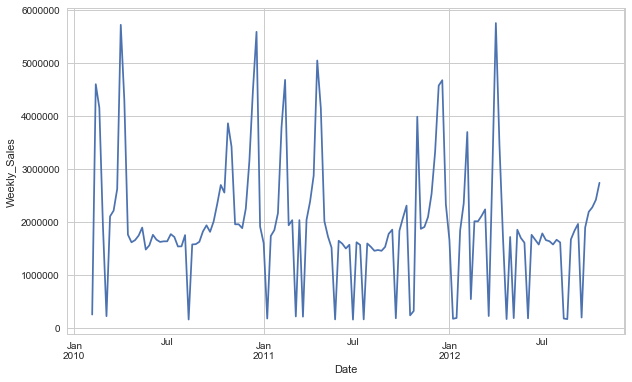

In [28]:
#dataset_1['Weekly_Sales'].plot()
#plt.savefig("Weekly_Sales of Department 1")
fig(dataset_1['Weekly_Sales'],'Weekly_Sales of Department 1', 'Date','Weekly_Sales' )

In [29]:
from statsmodels.tsa.stattools import adfuller
print('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(dataset_1['Weekly_Sales'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.709722e+00
p-value                        1.273372e-11
#lags Used                     0.000000e+00
Number of Observations Used    1.420000e+02
Critical Value (1%)           -3.477262e+00
Critical Value (10%)          -2.577743e+00
Critical Value (5%)           -2.882118e+00
dtype: float64


__Note:__ 
-  p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
- As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -7.70 is less than the value of -3.47 at 1%.
- This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
- Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [30]:
dataset_1.tail()

,Store,Dept,Weekly_Sales,Day_Of_Week,Month,Year,Day
Date,,,,,,,
2012-09-28,1,1,1894781,4,9,2012,28
2012-10-05,1,1,2190447,4,10,2012,5
2012-10-12,1,1,2276401,4,10,2012,12
2012-10-19,1,1,2418527,4,10,2012,19
2012-10-26,1,1,2739081,4,10,2012,26


In [31]:
dataset_1.head()

,Store,Dept,Weekly_Sales,Day_Of_Week,Month,Year,Day
Date,,,,,,,
2010-02-05,1,1,249245,4,2,2010,5
2010-02-12,1,1,4603949,4,2,2010,12
2010-02-19,1,1,4159555,4,2,2010,19
2010-02-26,1,1,1940354,4,2,2010,26
2010-03-05,1,1,218279,4,3,2010,5


In [32]:
monthly_sales_data = pd.pivot_table(dataset_1, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = [1,2,3,4,5,6,7,8,9,10,11,12])
monthly_sales_data

Year,2010,2011,2012
Month,,,
1,NaN,1338071.50,961795.00
2,2738275.75,3144065.75,2150730.25
3,1789800.75,1121949.75,1895672.20
4,3010335.20,3301139.00,2772182.00
5,1667353.75,1352107.00,1361130.00
6,1668517.50,1574464.25,1354942.80
7,1638300.20,1016782.80,1661719.75
8,1264901.25,1476548.75,1055803.60
9,1797831.75,1433660.80,1470288.75


<Figure size 720x432 with 0 Axes>

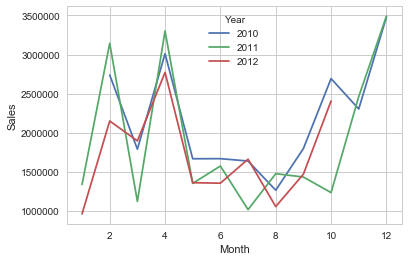

In [33]:
fig(monthly_sales_data, 'Monthly Sales', 'Month', 'Sales')
#monthly_sales_data.plot(figsize=(8,6))
#ax.set_xlabel('Month')
#ax.set_ylabel('Weekly_Sales')
#plt.legend()

#plt.show()

** Note:** There is a trend in monthly sales data which is followed through years. As the year proceeds, the sales goes higher until February and on March it drops but hits up again. The market slows down during summer and again gear up from September/October onwards. 


In [34]:
yearly_sales_data = pd.pivot_table(dataset_1, values = "Weekly_Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[[1,2,3,4,5,6,7,8,9,10, 11, 12]]
yearly_sales_data

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2010,NaN,2738275.75,1789800.75,3010335.2,1667353.75,1668517.50,1638300.20,1264901.25,1797831.75,2692890.6,2304035.00,3479677.6
2011,1338071.5,3144065.75,1121949.75,3301139.0,1352107.00,1574464.25,1016782.80,1476548.75,1433660.80,1234207.5,2463437.75,3490241.4
2012,961795.0,2150730.25,1895672.20,2772182.0,1361130.00,1354942.80,1661719.75,1055803.60,1470288.75,2406114.0,NaN,NaN


Text(0,0.5,'Sales')

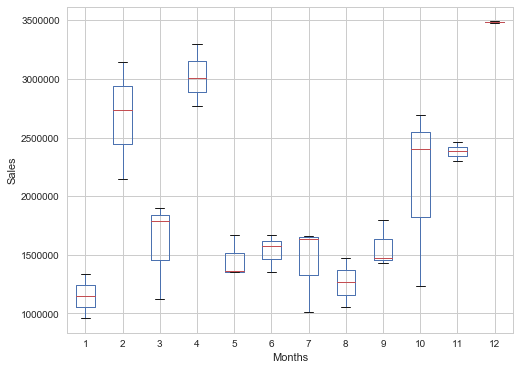

In [35]:
yearly_sales_data.boxplot(figsize=(8,6))
plt.xlabel('Months')
plt.ylabel('Sales')


** Note:** Following the seasonality over three years, the fluctuation of yearly sales has been shown here on mothly basis.

In [36]:
def tsplot2(y, title, lags= None, figsize=(12,8)):
    '''Examine the pattern of ACF and PACF, along with the time series plot and histogram.'''
    fig = plt.figure(figsize = figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize= 14)
    y.plot(ax= hist_ax, kind = 'hist', bins= 25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax= acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax= pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x1e81a2169b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e819cc2080>)

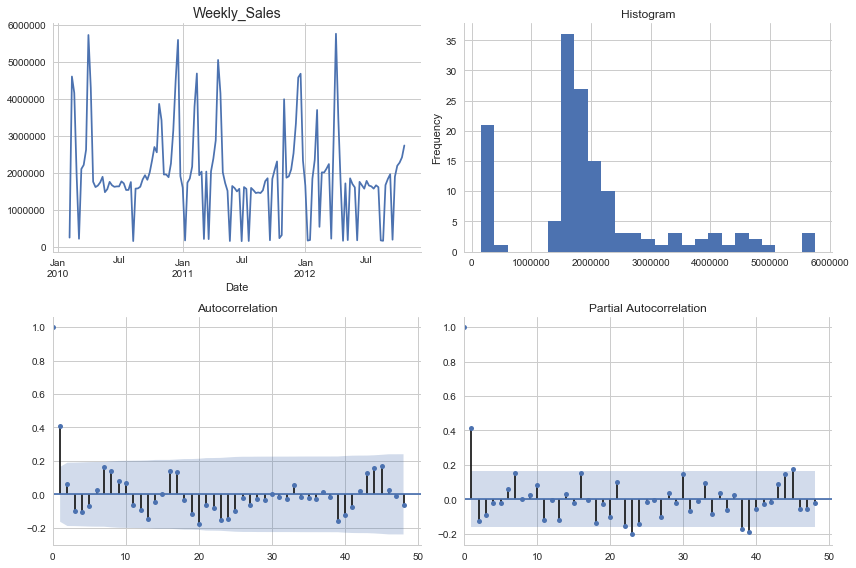

In [37]:
tsplot2(dataset_1['Weekly_Sales'].dropna(), title = 'Weekly_Sales', lags = 48)

In [38]:
decomposition = sm.tsa.seasonal_decompose(dataset_1['Weekly_Sales'], model='multiplicative')


** Note: ** 
- Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.
- Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.
- Three systematic components including level (Observed), trend, seasonality, and one non-systematic component called noise (Residual).

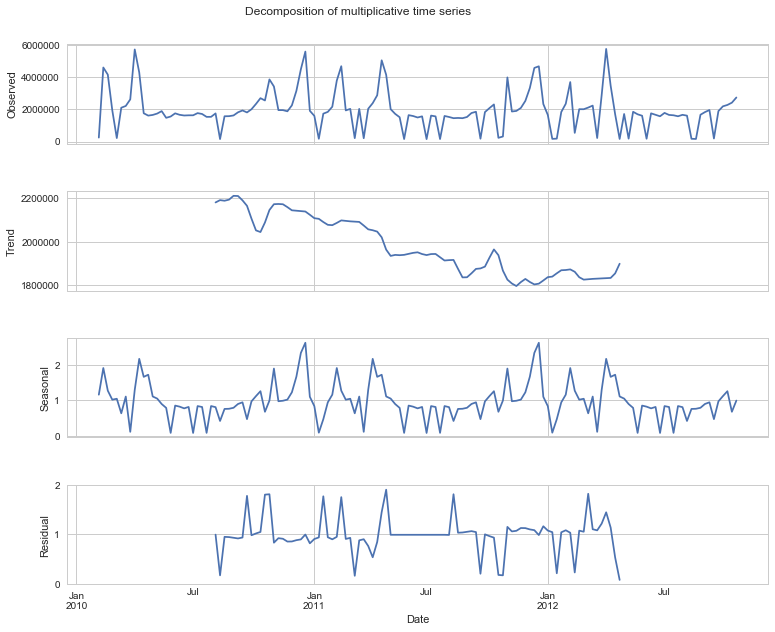

In [39]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(10)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

-  Level: The average value in the series.
-  Trend: The increasing or decreasing value in the series.
-  Seasonality: The repeating short-term cycle in the series.
-  Noise: The random residuals, which are the time series after the trend,variation in the series.
-  Residual:The time series after the trend.

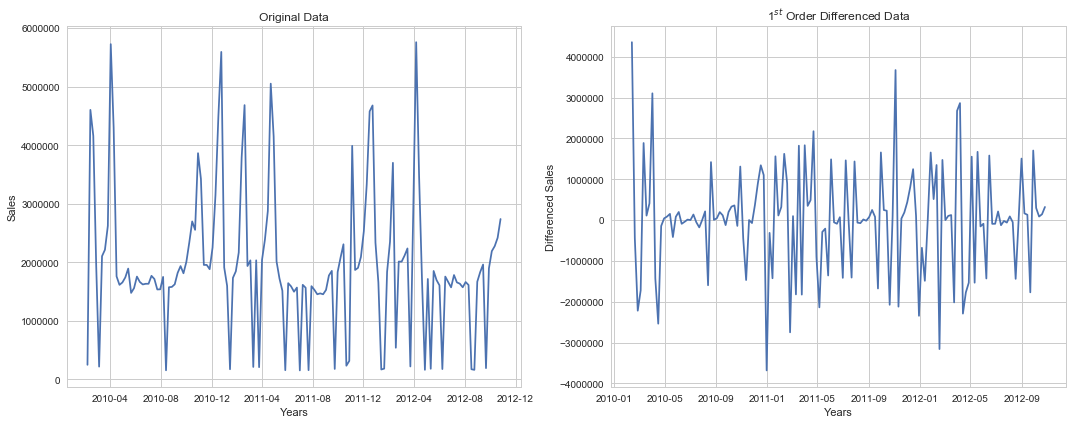

In [40]:
random_df=pd.DataFrame(dataset_1['Weekly_Sales'])

fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(15)
fig.set_figheight(6)

axes[0].plot(random_df.index, random_df['Weekly_Sales'])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Data")

axes[1].plot(random_df.index, random_df['Weekly_Sales'].diff(periods=1)) # First discrete difference of element.
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")

plt.tight_layout()
plt.show()

In [41]:
ts_log = np.log10(random_df)
ts_log.dropna(inplace=True)

ts_log_diff = ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
ts_log_diff.dropna(inplace=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x1e819b84240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e81a54f438>)

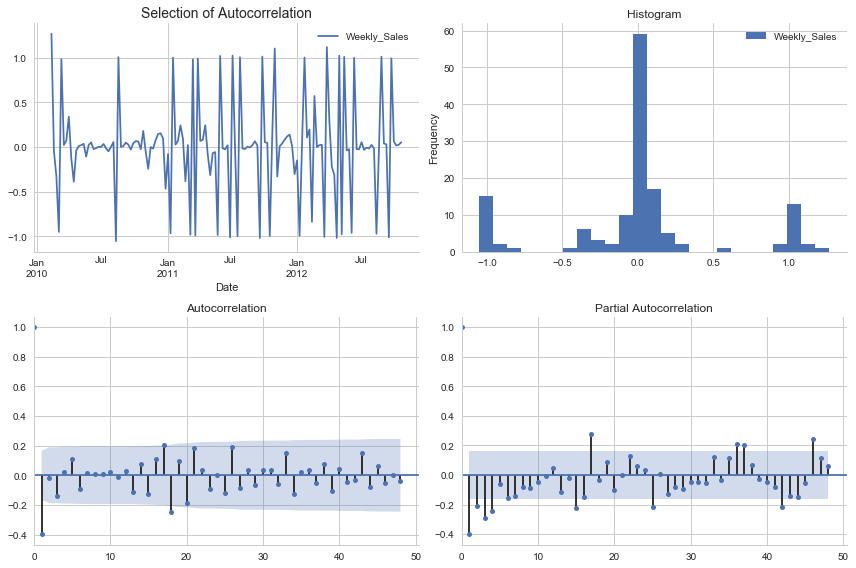

In [42]:
 tsplot2(ts_log_diff.dropna(), title = "Selection of Autocorrelation", lags = 48)

In [43]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [44]:
import warnings
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 model - AIC:151.3682782885412


**Note:** The above output suggests that SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 yields the lowest AIC value of 151.3682782885412. Therefore we should consider this to be optimal option.

## Fitting the SARIMA Model 

In [45]:
best_model = sm.tsa.statespace.SARIMAX(ts_log,
                                      order=(1, 1, 1),
                                      seasonal_order=(0, 0, 0, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [46]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                           Statespace Model Results                           
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -72.684
Date:                Wed, 23 Jan 2019   AIC                            151.368
Time:                        04:22:00   BIC                            160.236
Sample:                    02-05-2010   HQIC                           154.972
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1399      0.101      1.383      0.167      -0.058       0.338
ma.L1         -0.9827      0.033    -29.982      0.000      -1.047      -0.918
sigma2         0.1595      0.015     10.570      0.0

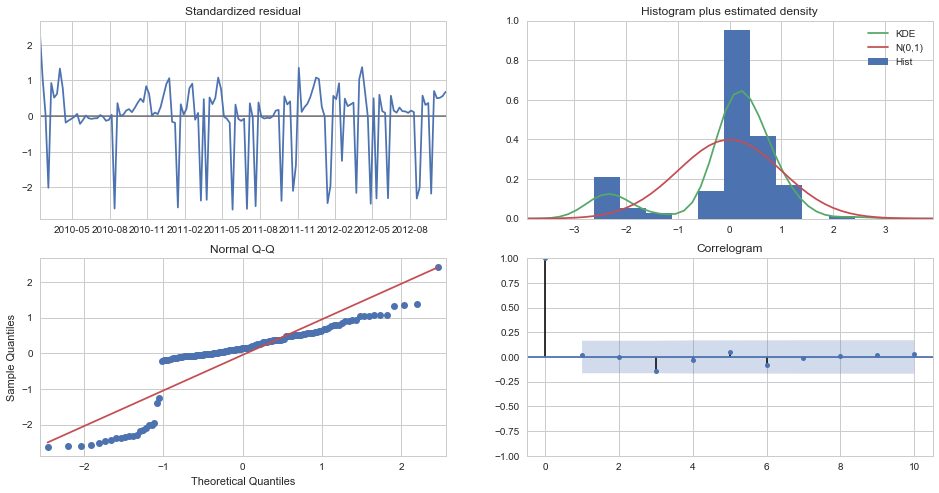

In [47]:
best_results.plot_diagnostics(figsize=(16, 8))
plt.show()

**Note::** We should always run model diagnostics to investigate any unusual behavior.
-  It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

## Validating forecasts

-  To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and and we set forecasts to start at 2012-05-04 to the end of the data.


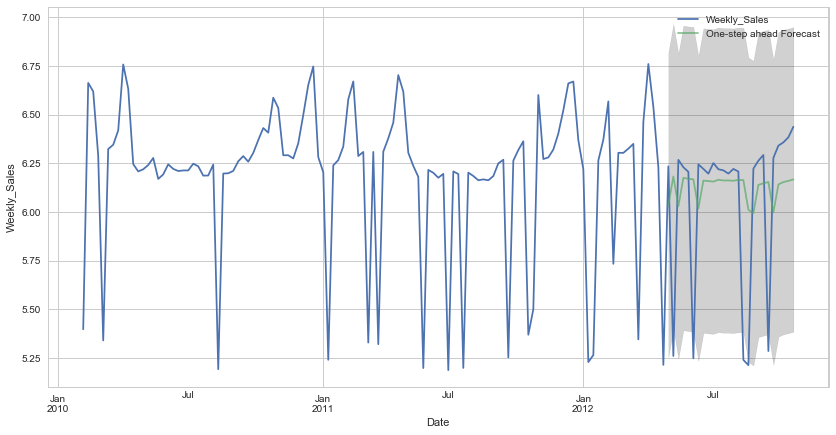

In [48]:
pred = best_results.get_prediction(start=pd.to_datetime('2012-05-04'), dynamic=False)
pred_ci = pred.conf_int()

ax = ts_log['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Weekly_Sales')
plt.legend()

plt.show()

**Note:** The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing the trend and captured the seasonality.

In [49]:
ts_forecasted = pred.predicted_mean
ts_truth = ts_log['2012-05-04':]

# Compute the mean square error
mse = ((ts_forecasted - ts_truth['Weekly_Sales']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse,4)))


The Mean Squared Error of our forecasts is 0.1731


-  The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

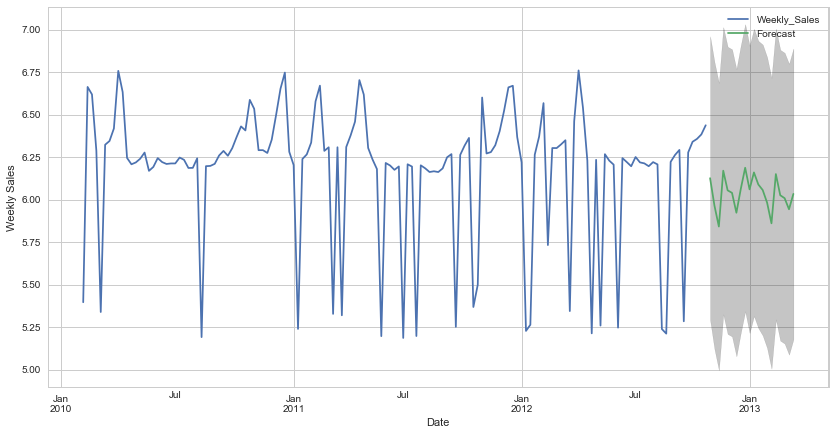

In [51]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()

ax = ts_log.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')

plt.legend()
plt.show()